<a href="https://colab.research.google.com/github/gx6hrtpvj6-glitch/facial-emotion-recognition/blob/main/FER_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [178]:

# 1. Imports and config


import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from google.colab import drive

from skimage.feature import hog

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import f1_score, balanced_accuracy_score

def eval_metrics(name, y_true, y_pred):
    return {
        "Run": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "BalancedAcc": balanced_accuracy_score(y_true, y_pred),
        "MacroF1": f1_score(y_true, y_pred, average="macro")
    }

IMG_SIZE = (64, 64)   # (H, W)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [179]:

# 2. Mount Drive and paths

drive.mount("/content/drive")

ROOT_DIR = "/content/drive/MyDrive/CO3519"

# CHANGE THESE NAMES IF YOUR FOLDERS ARE DIFFERENT
JAFFE_FOLDER = "JAFFE_7030"      # e.g. renamed from JAFFE-[70,30]
CK_FOLDER    = "CK_dataset"

JAFFE_DIR = os.path.join(ROOT_DIR, JAFFE_FOLDER)
CK_DIR    = os.path.join(ROOT_DIR, CK_FOLDER)

print("CO3519 contents:", os.listdir(ROOT_DIR))
print("JAFFE_DIR:", JAFFE_DIR)
print("CK_DIR   :", CK_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CO3519 contents: ['CK_dataset', 'JAFFE_7030', 'report_figures']
JAFFE_DIR: /content/drive/MyDrive/CO3519/JAFFE_7030
CK_DIR   : /content/drive/MyDrive/CO3519/CK_dataset


In [180]:

# 3. Preprocessing + feature extractors

def preprocess_image(path):
    """Read image, convert to grayscale, resize, normalise to [0,1]."""
    img = cv2.imread(path)
    if img is None:
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE)
    img = img.astype("float32") / 255.0
    return img

def preprocess_dataset(paths):
    images = []
    valid_idx = []
    for i, p in enumerate(paths):
        img = preprocess_image(p)
        if img is not None:
            images.append(img)
            valid_idx.append(i)
    return np.array(images), np.array(valid_idx)

def hog_features(img):
    """HOG on a single grayscale image."""
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE)

    features = hog(
        img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        visualize=False,
        channel_axis=None
    )
    return features

def compute_features_batch(X):
    """Compute HOG features for a batch of images."""
    feats = []
    for img in X:
        feats.append(hog_features(img))
    return np.array(feats)



In [181]:

# 4. JAFFE DATASET

VALID_MAP = {
    "angry": "angry", "anger": "angry",
    "fear": "fear", "afraid": "fear",
    "happy": "happy", "happiness": "happy",
    "neutral": "neutral",
    "sad": "sad", "sadness": "sad",
    "surprise": "surprise", "surprised": "surprise"
}

def load_from_root(root_dir):
    paths = []
    labels = []
    for r, dirs, files in os.walk(root_dir):
        folder = os.path.basename(r).lower()
        label = VALID_MAP.get(folder, None)

        for f in files:
            if f.lower().endswith((".jpg", ".jpeg", ".png", ".tif", ".tiff")):
                if label is not None:
                    paths.append(os.path.join(r, f))
                    labels.append(label)

    return paths, labels

# 1) Load all JAFFE image paths + labels
jaffe_paths, jaffe_labels = load_from_root(JAFFE_DIR)
print("JAFFE images (raw):", len(jaffe_paths))

# 2) Preprocess images, keep only valid ones
X_jaffe, idx_valid = preprocess_dataset(jaffe_paths)
y_jaffe = np.array(jaffe_labels)[idx_valid]
paths_valid = np.array(jaffe_paths)[idx_valid]

print("Valid JAFFE images:", X_jaffe.shape[0])

# 3) Compute HOG features
X_jaffe_hog = compute_features_batch(X_jaffe)
print("JAFFE HOG:", X_jaffe_hog.shape)

# 4) Single train/test split (shared by HOG and paths)
indices = np.arange(len(y_jaffe))
train_idx, test_idx = train_test_split(
    indices,
    test_size=0.3,
    stratify=y_jaffe,
    random_state=RANDOM_STATE
)

X_hog_train = X_jaffe_hog[train_idx]
X_hog_test  = X_jaffe_hog[test_idx]

y_train = y_jaffe[train_idx]
y_test  = y_jaffe[test_idx]

jaffe_train_paths  = paths_valid[train_idx]
jaffe_test_paths   = paths_valid[test_idx]
jaffe_train_labels = y_train
jaffe_test_labels  = y_test

print("JAFFE train:", X_hog_train.shape[0], " test:", X_hog_test.shape[0])

# 5) Train classifiers – HOG
svm_jaffe = SVC(kernel="rbf", C=10, gamma="scale", random_state=RANDOM_STATE)
svm_jaffe.fit(X_hog_train, y_train)

knn_jaffe = KNeighborsClassifier(n_neighbors=5)
knn_jaffe.fit(X_hog_train, y_train)

nb_jaffe = GaussianNB()
nb_jaffe.fit(X_hog_train, y_train)

# 6) Evaluation helper returning both predictions and accuracy
def eval_model(name, clf, X_te, y_te):
    y_pred = clf.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    print(f"\n=== {name} ===")
    print("Accuracy:", acc)
    print(classification_report(y_te, y_pred))
    return y_pred, acc

# 7) Evaluate HOG models
y_pred_svm_jaffe_hog, accuracy_svm_jaffe_hog = eval_model(
    "JAFFE HOG + SVM", svm_jaffe, X_hog_test, y_test
)
y_pred_knn_jaffe_hog, accuracy_knn_jaffe_hog = eval_model(
    "JAFFE HOG + KNN", knn_jaffe, X_hog_test, y_test
)
y_pred_nb_jaffe_hog, accuracy_nb_jaffe_hog = eval_model(
    "JAFFE HOG + NB", nb_jaffe, X_hog_test, y_test
)



JAFFE images (raw): 183
Valid JAFFE images: 183
JAFFE HOG: (183, 1764)
JAFFE train: 128  test: 55

=== JAFFE HOG + SVM ===
Accuracy: 0.8727272727272727
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00         8
        fear       0.88      0.78      0.82         9
       happy       0.80      0.80      0.80        10
     neutral       0.77      1.00      0.87        10
         sad       0.89      0.89      0.89         9
    surprise       1.00      0.78      0.88         9

    accuracy                           0.87        55
   macro avg       0.89      0.87      0.88        55
weighted avg       0.88      0.87      0.87        55


=== JAFFE HOG + KNN ===
Accuracy: 0.3090909090909091
              precision    recall  f1-score   support

       angry       0.46      0.75      0.57         8
        fear       0.30      0.33      0.32         9
       happy       0.27      0.40      0.32        10
     neutral       0.27      0.30 

In [182]:

# 5. CK DATASET (train / test split)

def load_ck_split(split):
    """
    Load CK image paths and labels from the 'train' or 'test' subfolder.
    Folder names (angry, happy, etc.) are mapped to labels via VALID_MAP.
    """
    split_dir = os.path.join(CK_DIR, split)   # 'train' or 'test'
    paths, labels = [], []
    for r, dirs, files in os.walk(split_dir):
        folder = os.path.basename(r).lower()
        label = VALID_MAP.get(folder, None)   # reuse same map
        for f in files:
            if f.lower().endswith((".jpg", ".jpeg", ".png", ".tif", ".tiff")):
                if label is not None:
                    paths.append(os.path.join(r, f))
                    labels.append(label)
    return paths, labels


# 1) Load CK train/test paths + labels
ck_train_paths, ck_train_labels = load_ck_split("train")
ck_test_paths,  ck_test_labels  = load_ck_split("test")

print("CK train paths:", len(ck_train_paths))
print("CK test paths :", len(ck_test_paths))
print("Example CK train:", ck_train_paths[0], ck_train_labels[0])

# 2) Preprocess CK images (train and test separately)
X_ck_train, idx_tr = preprocess_dataset(ck_train_paths)
y_ck_train = np.array(ck_train_labels)[idx_tr]

X_ck_test, idx_te = preprocess_dataset(ck_test_paths)
y_ck_test = np.array(ck_test_labels)[idx_te]

print("X_ck_train:", X_ck_train.shape, " X_ck_test:", X_ck_test.shape)

# 3) Compute HOG features
X_ck_train_hog = compute_features_batch(X_ck_train)
X_ck_test_hog  = compute_features_batch(X_ck_test)

print("CK train HOG:", X_ck_train_hog.shape)
print("CK test HOG :", X_ck_test_hog.shape)

# 4) Train models on HOG features
svm_ck = SVC(kernel="rbf", C=10, gamma="scale", random_state=RANDOM_STATE)
svm_ck.fit(X_ck_train_hog, y_ck_train)

knn_ck = KNeighborsClassifier(n_neighbors=5)
knn_ck.fit(X_ck_train_hog, y_ck_train)

nb_ck = GaussianNB()
nb_ck.fit(X_ck_train_hog, y_ck_train)

# 5) Evaluate models (store predictions + accuracies)
y_pred_svm_ck, accuracy_svm_ck = eval_model(
    "CK HOG + SVM", svm_ck, X_ck_test_hog, y_ck_test
)
y_pred_knn_ck, accuracy_knn_ck = eval_model(
    "CK HOG + KNN", knn_ck, X_ck_test_hog, y_ck_test
)
y_pred_nb_ck, accuracy_nb_ck = eval_model(
    "CK HOG + NB", nb_ck, X_ck_test_hog, y_ck_test
)



CK train paths: 341
CK test paths : 143
Example CK train: /content/drive/MyDrive/CO3519/CK_dataset/train/fear/16.jpg fear
X_ck_train: (341, 64, 64)  X_ck_test: (143, 64, 64)
CK train HOG: (341, 1764)
CK test HOG : (143, 1764)

=== CK HOG + SVM ===
Accuracy: 0.7342657342657343
              precision    recall  f1-score   support

       angry       0.88      0.35      0.50        20
        fear       0.00      0.00      0.00         5
       happy       0.90      0.90      0.90        29
     neutral       0.63      0.88      0.73        48
         sad       0.43      0.40      0.41        15
    surprise       0.96      0.92      0.94        26

    accuracy                           0.73       143
   macro avg       0.63      0.57      0.58       143
weighted avg       0.73      0.73      0.71       143


=== CK HOG + KNN ===
Accuracy: 0.6363636363636364
              precision    recall  f1-score   support

       angry       0.40      0.20      0.27        20
        fear       0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [183]:

# 6. Class imbalance handling: class-weighted SVM (balanced)

#  JAFFE: class-weighted SVM
svm_jaffe_bal = SVC(kernel="rbf", C=10, gamma="scale",
                    class_weight="balanced", random_state=RANDOM_STATE)
svm_jaffe_bal.fit(X_hog_train, y_train)

y_pred_svm_jaffe_bal = svm_jaffe_bal.predict(X_hog_test)

print("\n=== JAFFE HOG + SVM (class_weight=balanced) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm_jaffe_bal))
print(classification_report(y_test, y_pred_svm_jaffe_bal))

#  CK: class-weighted SVM
svm_ck_bal = SVC(kernel="rbf", C=10, gamma="scale",
                 class_weight="balanced", random_state=RANDOM_STATE)
svm_ck_bal.fit(X_ck_train_hog, y_ck_train)

y_pred_svm_ck_bal = svm_ck_bal.predict(X_ck_test_hog)

print("\n=== CK HOG + SVM (class_weight=balanced) ===")
print("Accuracy:", accuracy_score(y_ck_test, y_pred_svm_ck_bal))
print(classification_report(y_ck_test, y_pred_svm_ck_bal))

#  Table for report
df_bal_compare = pd.DataFrame([
    eval_metrics("JAFFE SVM baseline", y_test, y_pred_svm_jaffe_hog),
    eval_metrics("JAFFE SVM balanced", y_test, y_pred_svm_jaffe_bal),
    eval_metrics("CK SVM baseline",    y_ck_test, y_pred_svm_ck),
    eval_metrics("CK SVM balanced",    y_ck_test, y_pred_svm_ck_bal),
]).sort_values("Run")

display(df_bal_compare)



=== JAFFE HOG + SVM (class_weight=balanced) ===
Accuracy: 0.8727272727272727
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00         8
        fear       0.88      0.78      0.82         9
       happy       0.80      0.80      0.80        10
     neutral       0.77      1.00      0.87        10
         sad       0.89      0.89      0.89         9
    surprise       1.00      0.78      0.88         9

    accuracy                           0.87        55
   macro avg       0.89      0.87      0.88        55
weighted avg       0.88      0.87      0.87        55


=== CK HOG + SVM (class_weight=balanced) ===
Accuracy: 0.7272727272727273
              precision    recall  f1-score   support

       angry       0.78      0.35      0.48        20
        fear       0.00      0.00      0.00         5
       happy       0.90      0.90      0.90        29
     neutral       0.62      0.85      0.72        48
         sad       0.43      0.40

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Run,Accuracy,BalancedAcc,MacroF1
3,CK SVM balanced,0.727273,0.570633,0.575596
2,CK SVM baseline,0.734266,0.574105,0.580326
1,JAFFE SVM balanced,0.872727,0.874074,0.876164
0,JAFFE SVM baseline,0.872727,0.874074,0.876164


In [184]:

# 7. Cross-validation (Stratified K-Fold) for robustness

def cv_report(title, X, y, C=10, balanced=False):
    cw = "balanced" if balanced else None
    model = SVC(kernel="rbf", C=C, gamma="scale", class_weight=cw, random_state=RANDOM_STATE)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X, y, cv=skf, scoring="accuracy")
    print(f"\n{title}")
    print("CV Accuracy scores:", np.round(scores, 4))
    print(f"Mean ± Std: {scores.mean():.4f} ± {scores.std():.4f}")
    return scores

# JAFFE CV (use training set only to avoid leaking test set)
_ = cv_report("JAFFE HOG SVM (baseline) - 5-fold CV on train", X_hog_train, y_train, C=10, balanced=False)
_ = cv_report("JAFFE HOG SVM (balanced) - 5-fold CV on train", X_hog_train, y_train, C=10, balanced=True)

# CK CV
_ = cv_report("CK HOG SVM (baseline) - 5-fold CV on train", X_ck_train_hog, y_ck_train, C=10, balanced=False)
_ = cv_report("CK HOG SVM (balanced) - 5-fold CV on train", X_ck_train_hog, y_ck_train, C=10, balanced=True)



JAFFE HOG SVM (baseline) - 5-fold CV on train
CV Accuracy scores: [0.7692 0.7308 0.6538 0.64   0.6   ]
Mean ± Std: 0.6788 ± 0.0620

JAFFE HOG SVM (balanced) - 5-fold CV on train
CV Accuracy scores: [0.7692 0.7308 0.6538 0.64   0.6   ]
Mean ± Std: 0.6788 ± 0.0620

CK HOG SVM (baseline) - 5-fold CV on train
CV Accuracy scores: [0.6232 0.8235 0.6618 0.8088 0.75  ]
Mean ± Std: 0.7335 ± 0.0792

CK HOG SVM (balanced) - 5-fold CV on train
CV Accuracy scores: [0.6232 0.8235 0.6618 0.8088 0.75  ]
Mean ± Std: 0.7335 ± 0.0792


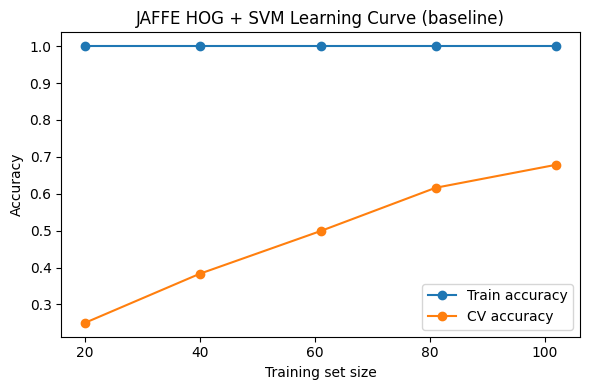

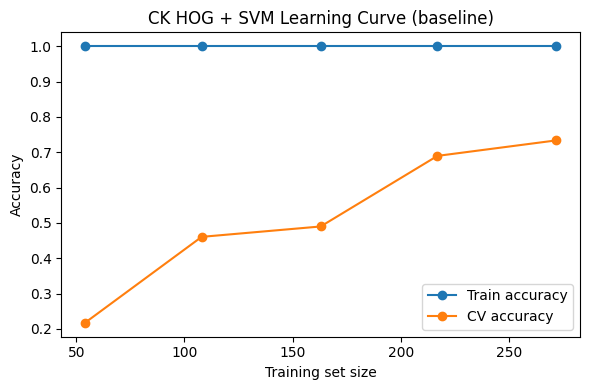

In [185]:

# 8. Learning curve (train vs validation accuracy)

def plot_learning_curve(title, X, y, C=10, balanced=False):
    cw = "balanced" if balanced else None
    clf = SVC(kernel="rbf", C=C, gamma="scale", class_weight=cw, random_state=RANDOM_STATE)

    train_sizes, train_scores, val_scores = learning_curve(
        clf, X, y,
        train_sizes=np.linspace(0.2, 1.0, 5),
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
        scoring="accuracy",
        n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure(figsize=(6,4))
    plt.plot(train_sizes, train_mean, marker="o", label="Train accuracy")
    plt.plot(train_sizes, val_mean, marker="o", label="CV accuracy")
    plt.xlabel("Training set size")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_learning_curve("JAFFE HOG + SVM Learning Curve (baseline)", X_hog_train, y_train, C=10, balanced=False)
plot_learning_curve("CK HOG + SVM Learning Curve (baseline)", X_ck_train_hog, y_ck_train, C=10, balanced=False)


In [186]:

# 9. Data augmentation experiment (training-only augmentation)

def augment_image(img):
    """Return a small list of augmented variants (mild transforms)."""
    out = []
    out.append(img)

    # horizontal flip
    out.append(cv2.flip(img, 1))

    # small rotations
    h, w = img.shape[:2]
    for angle in (-8, 8):
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        rot = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
        out.append(rot)

    return out

# --- JAFFE augmentation on training set only ---
X_jaffe_train_imgs = X_jaffe[train_idx]
y_jaffe_train_lbls = y_train

aug_imgs = []
aug_lbls = []

for img, lab in zip(X_jaffe_train_imgs, y_jaffe_train_lbls):
    for a in augment_image(img):
        aug_imgs.append(a)
        aug_lbls.append(lab)

aug_imgs = np.array(aug_imgs)
aug_lbls = np.array(aug_lbls)

X_aug_hog = compute_features_batch(aug_imgs)

# Train SVM on augmented data, test on original test split
svm_aug = SVC(kernel="rbf", C=10, gamma="scale", random_state=RANDOM_STATE)
svm_aug.fit(X_aug_hog, aug_lbls)

y_pred_aug = svm_aug.predict(X_hog_test)

print("\n=== JAFFE HOG + SVM (Augmented training) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_aug))
print(classification_report(y_test, y_pred_aug))

df_aug_compare = pd.DataFrame([
    eval_metrics("JAFFE SVM baseline",   y_test, y_pred_svm_jaffe_hog),
    eval_metrics("JAFFE SVM augmented",  y_test, y_pred_aug),
]).sort_values("Run")

display(df_aug_compare)



=== JAFFE HOG + SVM (Augmented training) ===
Accuracy: 0.8727272727272727
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00         8
        fear       0.80      0.89      0.84         9
       happy       0.90      0.90      0.90        10
     neutral       0.75      0.90      0.82        10
         sad       1.00      0.89      0.94         9
    surprise       0.86      0.67      0.75         9

    accuracy                           0.87        55
   macro avg       0.88      0.87      0.88        55
weighted avg       0.88      0.87      0.87        55



,Run,Accuracy,BalancedAcc,MacroF1
1,JAFFE SVM augmented,0.872727,0.874074,0.875244
0,JAFFE SVM baseline,0.872727,0.874074,0.876164


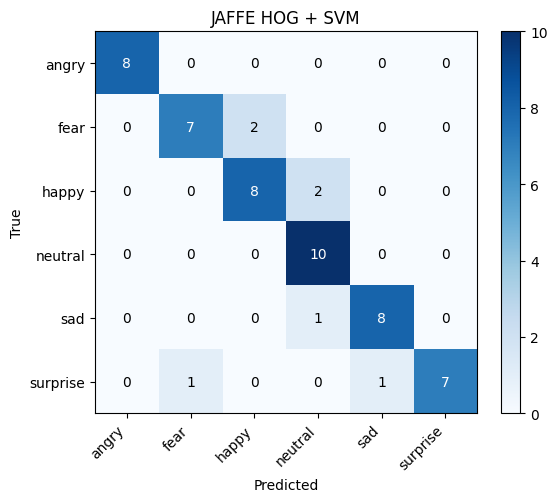

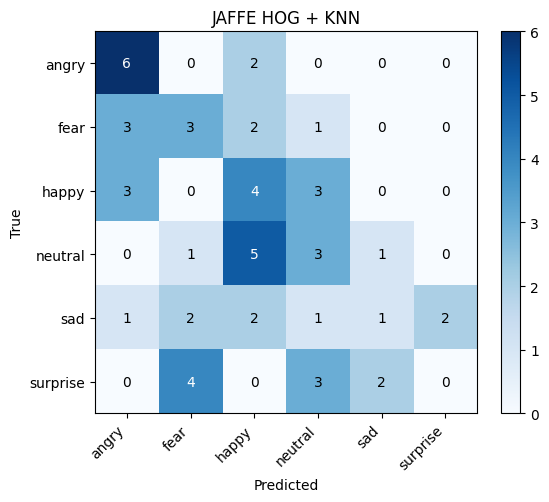

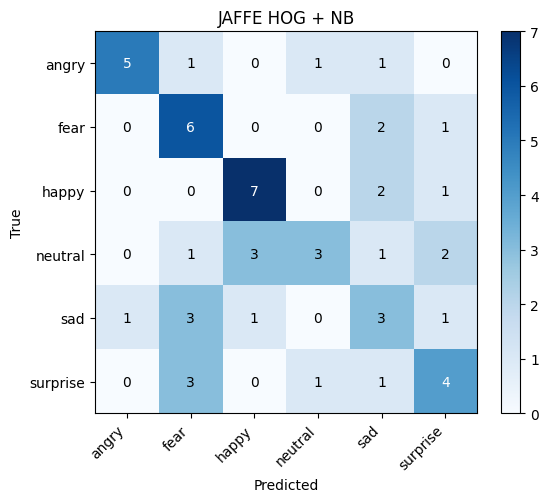

In [187]:

# 10 CONFUSION MATRICES – JAFFE


jaffe_classes = sorted(np.unique(y_jaffe))

def plot_cm(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_yticklabels(classes)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

# List of (title, y_true, y_pred) tuples for JAFFE
jaffe_cm_jobs = [
    ("JAFFE HOG + SVM", y_test, y_pred_svm_jaffe_hog),
    ("JAFFE HOG + KNN", y_test, y_pred_knn_jaffe_hog),
    ("JAFFE HOG + NB",  y_test, y_pred_nb_jaffe_hog),
]

# Plot all JAFFE confusion matrices
for title, y_true, y_pred in jaffe_cm_jobs:
    plot_cm(y_true, y_pred, jaffe_classes, title)



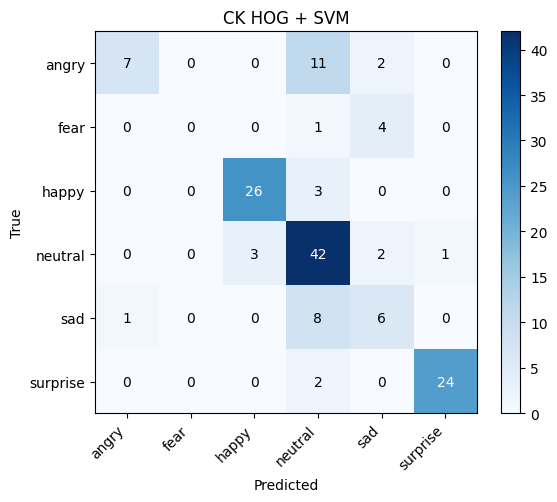

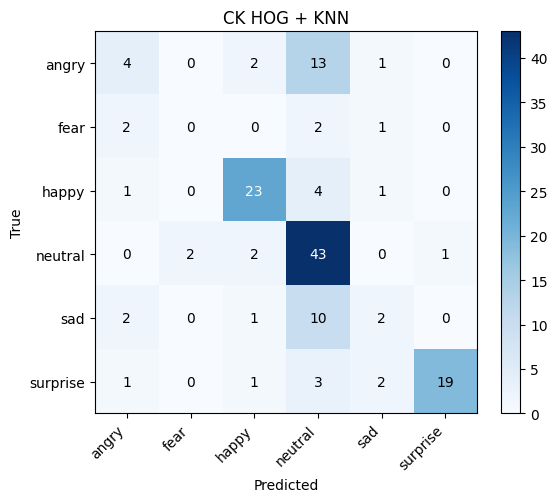

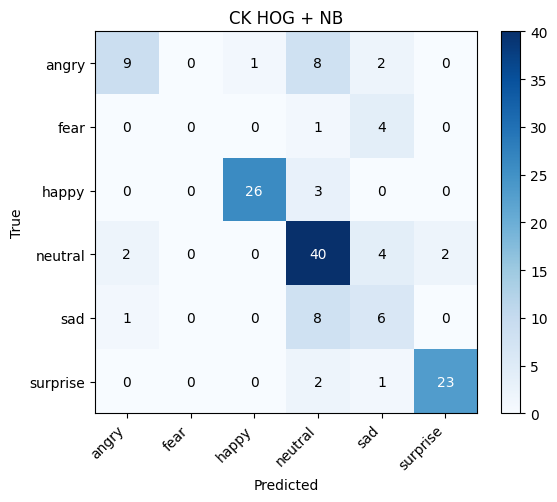

In [188]:

# 10.2 CONFUSION MATRICES – CK (HOG)

ck_classes = sorted(np.unique(y_ck_test))

# List of (title, y_true, y_pred) tuples for CK
ck_cm_jobs = [
    ("CK HOG + SVM", y_ck_test, y_pred_svm_ck),
    ("CK HOG + KNN", y_ck_test, y_pred_knn_ck),
    ("CK HOG + NB",  y_ck_test, y_pred_nb_ck),
]

# Plot all CK confusion matrices
for title, y_true, y_pred in ck_cm_jobs:
    plot_cm(y_true, y_pred, ck_classes, title)



In [189]:

# 11. VISUAL PREDICTIONS – JAFFE

def model_confidence(clf, feat):
    """
    Return a scalar 'confidence' score for a single sample:
    - if predict_proba exists: max class probability
    - elif decision_function exists: max decision score
    - else: None
    """
    if hasattr(clf, "predict_proba"):
        proba = clf.predict_proba(feat)
        return float(np.max(proba))
    elif hasattr(clf, "decision_function"):
        scores = clf.decision_function(feat)
        scores = scores[0] if scores.ndim > 1 else scores
        return float(np.max(scores))
    else:
        return None


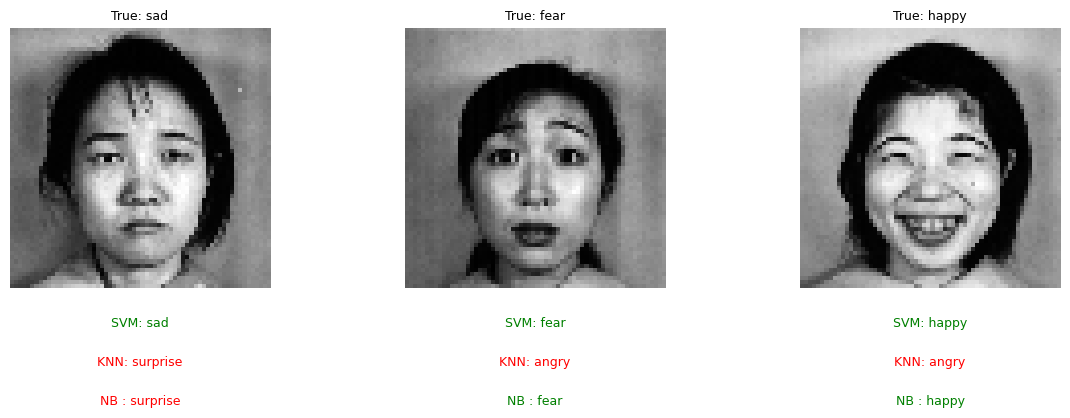

In [190]:
# 12. JAFFE – HOG models (SVM / KNN / NB)
def test_three_random_jaffe_hog():
    """
    Show 3 random JAFFE test images with predictions from
    SVM, KNN, NB using HOG features.
    """
    n = min(3, len(X_hog_test))
    if n == 0:
        print("No JAFFE test samples available.")
        return

    idxs = random.sample(range(len(X_hog_test)), n)
    plt.figure(figsize=(12, 4))

    for i, idx in enumerate(idxs):
        img_path   = jaffe_test_paths[idx]
        true_label = y_test[idx]

        img = preprocess_image(img_path)
        feat = X_hog_test[idx].reshape(1, -1)

        pred_svm = svm_jaffe.predict(feat)[0]
        pred_knn = knn_jaffe.predict(feat)[0]
        pred_nb  = nb_jaffe.predict(feat)[0]

        svm_ok = (pred_svm == true_label)
        knn_ok = (pred_knn == true_label)
        nb_ok  = (pred_nb  == true_label)

        ax = plt.subplot(1, 3, i + 1)
        ax.imshow(img, cmap="gray")

        ax.set_title(f"True: {true_label}", fontsize=9)
        ax.text(0.5, -0.15, f"SVM: {pred_svm}",
                color="green" if svm_ok else "red",
                fontsize=9, ha="center", transform=ax.transAxes)
        ax.text(0.5, -0.30, f"KNN: {pred_knn}",
                color="green" if knn_ok else "red",
                fontsize=9, ha="center", transform=ax.transAxes)
        ax.text(0.5, -0.45, f"NB : {pred_nb}",
                color="green" if nb_ok else "red",
                fontsize=9, ha="center", transform=ax.transAxes)

        ax.axis("off")

    plt.tight_layout()
    plt.show()


# Run HOG visualisation
test_three_random_jaffe_hog()



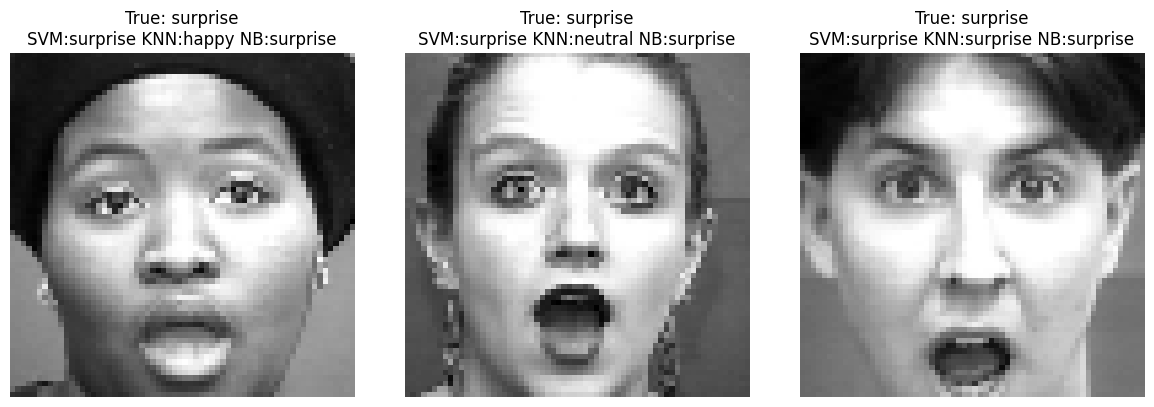

In [191]:
def test_three_random_ck():
    ck_test_paths_valid = np.array(ck_test_paths)[idx_te]  # align with y_ck_test
    n = min(3, len(ck_test_paths_valid))
    if n == 0:
        print("No CK test samples available.")
        return

    idxs = random.sample(range(len(ck_test_paths_valid)), n)
    plt.figure(figsize=(12, 4))

    for i, idx in enumerate(idxs):
        path = ck_test_paths_valid[idx]
        true_label = y_ck_test[idx]

        img = preprocess_image(path)
        feat = hog_features(img).reshape(1, -1)

        pred_svm = svm_ck.predict(feat)[0]
        pred_knn = knn_ck.predict(feat)[0]
        pred_nb  = nb_ck.predict(feat)[0]

        plt.subplot(1, 3, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"True: {true_label}\nSVM:{pred_svm} KNN:{pred_knn} NB:{pred_nb}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

test_three_random_ck()



In [192]:

# 13. ACCURACY SUMMARY TABLE

summary_data = {
    "Dataset": [],
    "Feature": [],
    "Model": [],
    "Accuracy": []
}

# ==== JAFFE HOG ====
summary_data["Dataset"].append("JAFFE")
summary_data["Feature"].append("HOG")
summary_data["Model"].append("SVM")
summary_data["Accuracy"].append(accuracy_svm_jaffe_hog)

summary_data["Dataset"].append("JAFFE")
summary_data["Feature"].append("HOG")
summary_data["Model"].append("KNN")
summary_data["Accuracy"].append(accuracy_knn_jaffe_hog)

summary_data["Dataset"].append("JAFFE")
summary_data["Feature"].append("HOG")
summary_data["Model"].append("NB")
summary_data["Accuracy"].append(accuracy_nb_jaffe_hog)

# ==== CK HOG ====
summary_data["Dataset"].append("CK")
summary_data["Feature"].append("HOG")
summary_data["Model"].append("SVM")
summary_data["Accuracy"].append(accuracy_svm_ck)

summary_data["Dataset"].append("CK")
summary_data["Feature"].append("HOG")
summary_data["Model"].append("KNN")
summary_data["Accuracy"].append(accuracy_knn_ck)

summary_data["Dataset"].append("CK")
summary_data["Feature"].append("HOG")
summary_data["Model"].append("NB")
summary_data["Accuracy"].append(accuracy_nb_ck)

# Convert to DataFrame for nice table output
df_summary = pd.DataFrame(summary_data)

# Sort for readability
df_summary = df_summary.sort_values(by=["Dataset", "Feature", "Model"])

print("=== ACCURACY SUMMARY TABLE ===")
display(df_summary)


=== ACCURACY SUMMARY TABLE ===


,Dataset,Feature,Model,Accuracy
4,CK,HOG,KNN,0.636364
5,CK,HOG,NB,0.727273
3,CK,HOG,SVM,0.734266
1,JAFFE,HOG,KNN,0.309091
2,JAFFE,HOG,NB,0.509091
0,JAFFE,HOG,SVM,0.872727


In [193]:

# 14. Stronger metrics (macro-F1, balanced accuracy) summary


rows = []
rows.append(eval_metrics("JAFFE HOG + SVM", y_test, y_pred_svm_jaffe_hog))
rows.append(eval_metrics("JAFFE HOG + KNN", y_test, y_pred_knn_jaffe_hog))
rows.append(eval_metrics("JAFFE HOG + NB",  y_test, y_pred_nb_jaffe_hog))

rows.append(eval_metrics("CK HOG + SVM", y_ck_test, y_pred_svm_ck))
rows.append(eval_metrics("CK HOG + KNN", y_ck_test, y_pred_knn_ck))
rows.append(eval_metrics("CK HOG + NB",  y_ck_test, y_pred_nb_ck))

df_metrics = pd.DataFrame(rows).sort_values(by=["Run"])
display(df_metrics)


,Run,Accuracy,BalancedAcc,MacroF1
4,CK HOG + KNN,0.636364,0.458840,0.461144
5,CK HOG + NB,0.727273,0.577417,0.582551
3,CK HOG + SVM,0.734266,0.574105,0.580326
1,JAFFE HOG + KNN,0.309091,0.315741,0.274463
2,JAFFE HOG + NB,0.509091,0.511574,0.510488
0,JAFFE HOG + SVM,0.872727,0.874074,0.876164


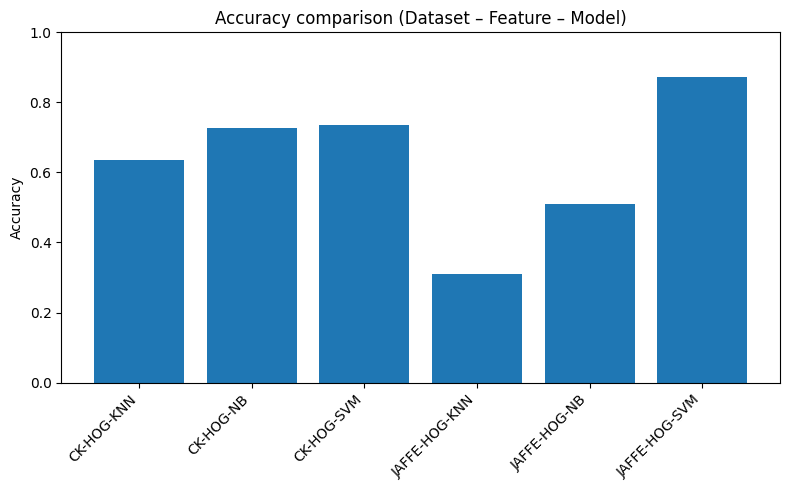

In [194]:

#  15. ACCURACY BAR PLOT

plt.figure(figsize=(8, 5))

# Create a compact label like "JAFFE-HOG-SVM"
labels = df_summary["Dataset"] + "-" + df_summary["Feature"] + "-" + df_summary["Model"]
accuracies = df_summary["Accuracy"]

plt.bar(labels, accuracies)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.title("Accuracy comparison (Dataset – Feature – Model)")
plt.tight_layout()
plt.show()


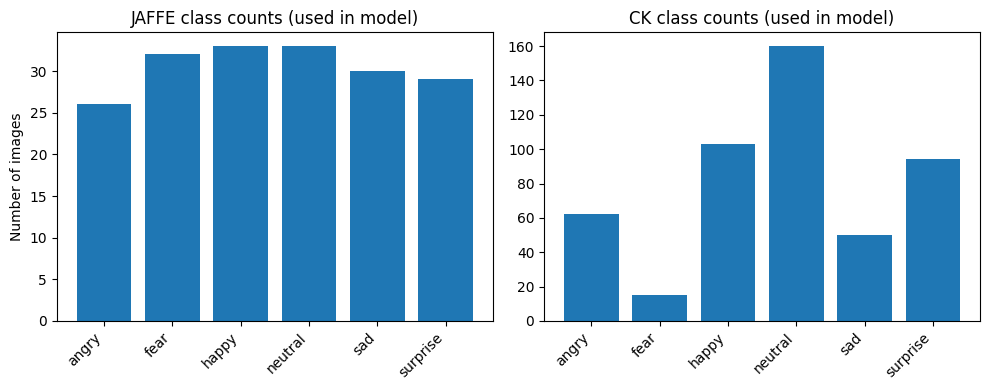

JAFFE counts (used):


,count
angry,26
fear,32
happy,33
neutral,33
sad,30
surprise,29



CK counts (used):


,count
angry,62
fear,15
happy,103
neutral,160
sad,50
surprise,94


In [195]:

# 16. CLASS DISTRIBUTION (IMBALANCE)

# JAFFE: use y_jaffe
jaffe_counts = pd.Series(y_jaffe).value_counts().sort_index()

# CK: use y_ck_train + y_ck_test
ck_all_labels = np.concatenate([y_ck_train, y_ck_test])
ck_counts = pd.Series(ck_all_labels).value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# JAFFE
axes[0].bar(jaffe_counts.index, jaffe_counts.values)
axes[0].set_title("JAFFE class counts (used in model)")
axes[0].set_ylabel("Number of images")
axes[0].set_xticks(range(len(jaffe_counts.index)))
axes[0].set_xticklabels(jaffe_counts.index, rotation=45, ha="right")

# CK
axes[1].bar(ck_counts.index, ck_counts.values)
axes[1].set_title("CK class counts (used in model)")
axes[1].set_xticks(range(len(ck_counts.index)))
axes[1].set_xticklabels(ck_counts.index, rotation=45, ha="right")

plt.tight_layout()
plt.show()

print("JAFFE counts (used):")
display(jaffe_counts)

print("\nCK counts (used):")
display(ck_counts)



C = 0.1: Accuracy = 0.2909
C = 1: Accuracy = 0.4000
C = 10: Accuracy = 0.8727
C = 100: Accuracy = 0.8727

=== JAFFE HOG – SVM C TUNING RESULTS ===


,C,Accuracy
0,0.1,0.290909
1,1.0,0.400000
2,10.0,0.872727
3,100.0,0.872727


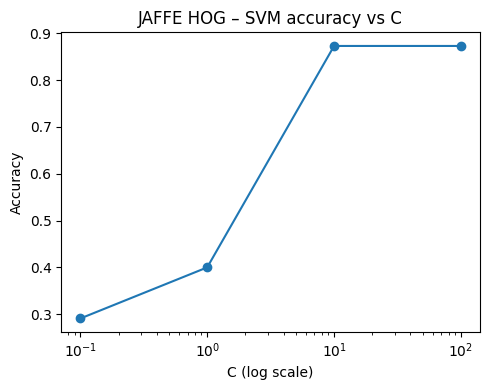

In [196]:

# 17. SVM PARAMETER TUNING (JAFFE HOG, vary C)

C_values = [0.1, 1, 10, 100]
tuning_results = []

for C_val in C_values:
    svm_temp = SVC(kernel="rbf", C=C_val, gamma="scale", random_state=RANDOM_STATE)
    svm_temp.fit(X_hog_train, y_train)
    y_pred_temp = svm_temp.predict(X_hog_test)
    acc_temp = accuracy_score(y_test, y_pred_temp)
    tuning_results.append({"C": C_val, "Accuracy": acc_temp})
    print(f"C = {C_val}: Accuracy = {acc_temp:.4f}")

df_tuning = pd.DataFrame(tuning_results)

print("\n=== JAFFE HOG – SVM C TUNING RESULTS ===")
display(df_tuning)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(df_tuning["C"], df_tuning["Accuracy"], marker="o")
plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("Accuracy")
plt.title("JAFFE HOG – SVM accuracy vs C")
plt.tight_layout()
plt.show()


In [197]:

# 18. Save figures to Drive for the report (reproducibility)

FIG_DIR = os.path.join(ROOT_DIR, "report_figures")
os.makedirs(FIG_DIR, exist_ok=True)
print("Saving figures to:", FIG_DIR)

def save_current_fig(filename):
    path = os.path.join(FIG_DIR, filename)
    plt.savefig(path, dpi=200, bbox_inches="tight")
    print("Saved:", path)

# Example usage:
# After any plt.show() plot, call save_current_fig("learning_curve_jaffe.png")
# After confusion matrix plot, call save_current_fig("cm_jaffe_svm.png")


Saving figures to: /content/drive/MyDrive/CO3519/report_figures
